In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import gym
from main.maml_agent import MAMLAgent, register_flags
register_flags()
from main.alpaca import *
from main.dataset import *
from main.dataViz import *
import yaml

from main.rover import *
from main.terrain import *

WARN: Cannot define MaxPoolGrad, likely already defined for this version of tensorflow: "Registering two gradient with name 'MaxPoolGrad'! (Previous registration was in register /home/somrita/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/registry.py:66)"


In [2]:
cfg_filename = 'configs/rocker-bogie-config.yml'
with open(cfg_filename,'r') as ymlfile:
    config = yaml.load(ymlfile)

/home/somrita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


### Set up rover geometry

In [3]:
alpha = np.deg2rad(110)
beta = np.deg2rad(90)

# Pick the angles at horizontal level motion
th1 = np.deg2rad(45)
th2 = np.deg2rad(60)

# Find all the arm lengths
l1 = 2.0
l2 = 1.0
rem_ht = l1*np.sin(th1) - l2 * np.cos(alpha + th1 - np.pi/2)
l3 = rem_ht/np.sin(th2)
l4 = rem_ht/np.cos(beta + th2 - np.pi/2)

wheel_rad_1 = 0.4
wheel_rad_2 = 0.4
wheel_rad_3 = 0.4

body_len = 2.0
body_wid = 0.2

rover = Rover(l1, l2, l3, l4, alpha, beta, gamma = th1, wheel_rad = wheel_rad_1, body_len = body_len, body_wid = body_wid)

### Set rover on flat terrain

In [4]:
rover.set_terrain(FlatTerrain())

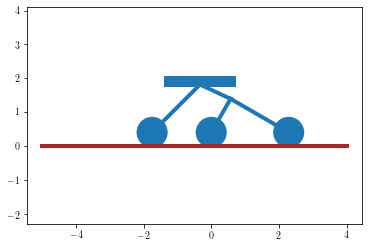

In [5]:
x2 = 0.0
r0, r1, rb, r2, r3 = rover.find_geom(x2)
ax = rover.plot_rover(r0, r1, rb, r2, r3)
plt.show()

### Set inertias

In [6]:
mass = 10.0 # kg
g = 9.81 # m/s2
rover.set_inertias(mass = mass, g = g)

# Dry land dataset

In [8]:
config['mu_range'] = config['mu_range_dry']
config['crr_range'] = config['crr_range_dry']
dataset_dry = RockerBogieDataset(config, rover)

config['mu_range'] = config['mu_range_gravel']
config['crr_range'] = config['crr_range_gravel']
dataset_gravel = RockerBogieDataset(config, rover)

config['mu_range'] = config['mu_range_sand']
config['crr_range'] = config['crr_range_sand']
dataset_sand = RockerBogieDataset(config, rover)

config['mu_range'] = config['mu_range_fixed']
config['crr_range'] = config['crr_range_fixed']
dataset_fixed = RockerBogieDataset(config, rover)

## Agent

In [9]:
g1 = tf.Graph()
sess1 = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=g1)
agent = ALPaCA(config, sess1, g1)
agent.construct_model()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device






Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

x_dim  5
y_dim  2
phi_dim  16
phi shape  (?, ?, 16)
context phi shape  (?, ?, 16)
K shape  (?, 16, 2)











In [10]:
agent.train(dataset_fixed,500)

loss: 722.43616
K shape  (?, 16, 2)
loss: -6.5564227
K shape  (?, 16, 2)
loss: -9.806382
K shape  (?, 16, 2)
loss: -8.965699
K shape  (?, 16, 2)
loss: -9.40096
K shape  (?, 16, 2)
loss: -9.462616
K shape  (?, 16, 2)
loss: -8.911678
K shape  (?, 16, 2)
loss: -8.144262
K shape  (?, 16, 2)
loss: -10.605441
K shape  (?, 16, 2)
loss: -8.496781
K shape  (?, 16, 2)


In [31]:
agent.save('rockerbogiemodels/rockerbogiemodel_fixed')

Saved to: rockerbogiemodels/rockerbogiemodel_fixed


In [10]:
# agent.restore('rockerbogiemodels/rockerbogiemodel_fixed')

INFO:tensorflow:Restoring parameters from rockerbogiemodel
Restored model from: rockerbogiemodel


# Other agents

In [12]:
g2 = tf.Graph()
sess2 = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=g2)
agent_dry = ALPaCA(config, sess2, g2)
agent_dry.construct_model()

g3 = tf.Graph()
sess3 = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=g3)
agent_gravel = ALPaCA(config, sess3, g3)
agent_gravel.construct_model()

g4 = tf.Graph()
sess4 = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=g4)
agent_sand = ALPaCA(config, sess4, g4)
agent_sand.construct_model()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



/home/somrita/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


x_dim  5
y_dim  2
phi_dim  16
phi shape  (?, ?, 16)
context phi shape  (?, ?, 16)
K shape  (?, 16, 2)


# Train and save models

In [13]:
agent_dry.train(dataset_dry,500)

loss: 374.6062
K shape  (?, 16, 2)
loss: -6.9632635
K shape  (?, 16, 2)
loss: -7.3569984
K shape  (?, 16, 2)
loss: -8.74477
K shape  (?, 16, 2)
loss: -10.528445
K shape  (?, 16, 2)
loss: -10.015294
K shape  (?, 16, 2)
loss: -10.055183
K shape  (?, 16, 2)
loss: -9.315346
K shape  (?, 16, 2)
loss: -9.338791
K shape  (?, 16, 2)
loss: -8.622468
K shape  (?, 16, 2)


In [32]:
agent_dry.save('rockerbogiemodels/rockerbogiemodel_dry')

Saved to: rockerbogiemodels/rockerbogiemodel_dry


In [16]:
agent_gravel.train(dataset_gravel,500)

loss: 450.67136
K shape  (?, 16, 2)
loss: -4.830266
K shape  (?, 16, 2)
loss: -9.556695
K shape  (?, 16, 2)
loss: -8.137547
K shape  (?, 16, 2)
loss: -9.867773
K shape  (?, 16, 2)
loss: -8.867906
K shape  (?, 16, 2)
loss: -8.722069
K shape  (?, 16, 2)
loss: -10.354387
K shape  (?, 16, 2)
loss: -10.747265
K shape  (?, 16, 2)
loss: -10.003495
K shape  (?, 16, 2)


In [33]:
agent_gravel.save('rockerbogiemodels/rockerbogiemodel_gravel')

Saved to: rockerbogiemodels/rockerbogiemodel_gravel


In [19]:
agent_sand.train(dataset_dry,500)

loss: 1473.316
K shape  (?, 16, 2)
loss: -0.9454898
K shape  (?, 16, 2)
loss: -5.2692213
K shape  (?, 16, 2)
loss: -5.5984626
K shape  (?, 16, 2)
loss: -8.075811
K shape  (?, 16, 2)
loss: -7.7255864
K shape  (?, 16, 2)
loss: -6.8601513
K shape  (?, 16, 2)
loss: -8.269824
K shape  (?, 16, 2)
loss: -9.779044
K shape  (?, 16, 2)
loss: -6.537305
K shape  (?, 16, 2)


In [34]:
agent_sand.save('rockerbogiemodels/rockerbogiemodel_sand')

Saved to: rockerbogiemodels/rockerbogiemodel_sand


# Load in saved models

In [35]:
agent.restore('rockerbogiemodels/rockerbogiemodel_fixed')
agent_dry.restore('rockerbogiemodels/rockerbogiemodel_dry')
agent_gravel.restore('rockerbogiemodels/rockerbogiemodel_gravel')
agent_sand.restore('rockerbogiemodels/rockerbogiemodel_sand')

INFO:tensorflow:Restoring parameters from rockerbogiemodels/rockerbogiemodel_fixed
Restored model from: rockerbogiemodels/rockerbogiemodel_fixed
INFO:tensorflow:Restoring parameters from rockerbogiemodels/rockerbogiemodel_dry
Restored model from: rockerbogiemodels/rockerbogiemodel_dry
INFO:tensorflow:Restoring parameters from rockerbogiemodels/rockerbogiemodel_gravel
Restored model from: rockerbogiemodels/rockerbogiemodel_gravel
INFO:tensorflow:Restoring parameters from rockerbogiemodels/rockerbogiemodel_sand
Restored model from: rockerbogiemodels/rockerbogiemodel_sand


# Visualize all agents

In [47]:
def get_NLL_MSE_time(N_test, test_horz, X_test, Y_test, agent):
    #compute MSE and time
    import time
    import tqdm

    def gaussian_nll(y,mu,Sig):
        n = 1
        logdet = np.log(Sig) 
        nll = n*np.log(2*np.pi) + logdet + ((y-mu).T * (1/Sig) * (y-mu))
        return 0.5*nll

    def MSE(y,mu):
        return (y-mu)**2

    def get_stats(meas, N):
        mean = sum(meas)/N
        var = sum([(nl - mean)**2 for nl in meas])/(N-1)
        return mean, var

    alpaca_nll_mean = []
    alpaca_nll_var = []
    alpaca_time_mean = []
    alpaca_time_var = []
    alpaca_mse_mean = []
    alpaca_mse_var = []

    lpaca_nll_mean = []
    lpaca_nll_var = []
    lpaca_time_mean = []
    lpaca_time_var = []

    for j in tqdm.tqdm(range(test_horz)):
        nll_list_alpaca = []
        nll_list_lpaca = []

        mse_list_alpaca = []

        time_list_alpaca = []
        time_list_lpaca = []

        for ind in range(N_test):
            X_update = X_test[ind:(ind+1),:j,:]
            Y_update = Y_test[ind:(ind+1),:j,:]
            x_pt = X_test[ind:(ind+1),(j):(j+1),:]
            y_pt = Y_test[ind:(ind+1),(j):(j+1),:]

            t1_alpaca = time.process_time()
            y, s = agent.test(X_update, Y_update, x_pt)
            t2_alpaca = time.process_time()

    #         t1_lpaca = time.process_time()
    #         y_lpaca,s_lpaca = agent_nometa.test(X_update, Y_update, x_pt)
    #         t2_lpaca = time.process_time()  

            nll_list_alpaca.append(gaussian_nll(y_pt[0,0,0],y[0,0,0],s[0,0,0,0]))
    #         nll_list_lpaca.append(gaussian_nll(y_pt[0,0,0],y_lpaca[0,0,0],s_lpaca[0,0,0,0]))

            time_list_alpaca.append(t2_alpaca - t1_alpaca)
    #         time_list_lpaca.append(t2_lpaca - t1_lpaca)

            mse_list_alpaca.append(MSE(y_pt[0,0,0],y[0,0,0]))

        time_mean_alpaca, time_var_alpaca = get_stats(time_list_alpaca,N_test)
    #     time_mean_lpaca, time_var_lpaca = get_stats(time_list_lpaca,N_test)

        mse_mean_alpaca, mse_var_alpaca = get_stats(mse_list_alpaca,N_test)

        nll_mean_alpaca, nll_var_alpaca = get_stats(nll_list_alpaca,N_test)
    #     nll_mean_lpaca, nll_var_lpaca = get_stats(nll_list_lpaca,N_test)

        alpaca_time_mean.append(time_mean_alpaca)
        alpaca_time_var.append(time_var_alpaca)

    #     lpaca_time_mean.append(time_mean_lpaca)
    #     lpaca_time_var.append(time_var_lpaca)

        alpaca_mse_mean.append(mse_mean_alpaca)
        alpaca_mse_var.append(mse_var_alpaca)

        alpaca_nll_mean.append(nll_mean_alpaca)
        alpaca_nll_var.append(nll_var_alpaca)

    #     lpaca_nll_mean.append(nll_mean_lpaca)
    #     lpaca_nll_var.append(nll_var_lpaca)
    return alpaca_nll_mean, alpaca_nll_var, alpaca_time_mean, alpaca_time_var, alpaca_mse_mean, alpaca_mse_var

In [48]:
N_test = 50
test_horz = 30
X_test, Y_test = dataset_fixed.sample(N_test, test_horz)
alpaca_nll_mean, alpaca_nll_var, alpaca_time_mean, alpaca_time_var, alpaca_mse_mean, alpaca_mse_var = get_NLL_MSE_time(N_test, test_horz, X_test, Y_test, agent)

100%|██████████| 30/30 [00:01<00:00, 24.14it/s]


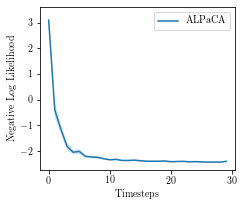

In [49]:
plt.figure(figsize=(3.5,3))
nll_plot(alpaca_nll_mean,alpaca_nll_var, None, None, None, None,N_test,legend=True)
# nll_plot(alpaca_nll_mean,alpaca_nll_var,lpaca_nll_mean,lpaca_nll_var,gp_nll_mean,gp_nll_var,N_test,legend=True)
# plt.savefig('figures/nll_rockerbogie.pdf')
plt.show()

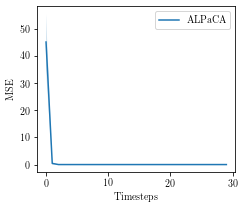

In [50]:
plt.figure(figsize=(3.5,3))
mse_plot(alpaca_mse_mean,alpaca_mse_var,None,None,None,None,N_test,legend=True)
plt.tight_layout()
# plt.savefig('figures/mse_rockerbogie.pdf')
plt.show()

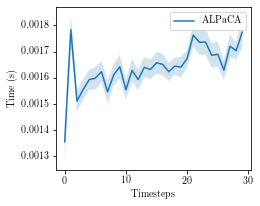

In [51]:
plt.figure(figsize=(3.5,3))
time_plot(alpaca_time_mean,alpaca_time_var,None,None,None,None,N_test,legend=True)
# time_plot(alpaca_time_mean,alpaca_time_var,lpaca_time_mean,lpaca_time_var,gp_time_mean,gp_time_var,N_test,legend=True)
# plt.savefig('figures/time_rockerbogie.pdf')
plt.show()

In [53]:
N_test = 50
test_horz = 30
X_test, Y_test = dataset_dry.sample(N_test, test_horz)
dry_nll_mean, dry_nll_var, dry_time_mean, dry_time_var, dry_mse_mean, dry_mse_var = get_NLL_MSE_time(N_test, test_horz, X_test, Y_test, agent_dry)

X_test, Y_test = dataset_gravel.sample(N_test, test_horz)
gravel_nll_mean, gravel_nll_var, gravel_time_mean, gravel_time_var, gravel_mse_mean, gravel_mse_var = get_NLL_MSE_time(N_test, test_horz, X_test, Y_test, agent_gravel)

X_test, Y_test = dataset_sand.sample(N_test, test_horz)
sand_nll_mean, sand_nll_var, sand_time_mean, sand_time_var, sand_mse_mean, sand_mse_var = get_NLL_MSE_time(N_test, test_horz, X_test, Y_test, agent_sand)



100%|██████████| 30/30 [00:00<00:00, 30.41it/s]


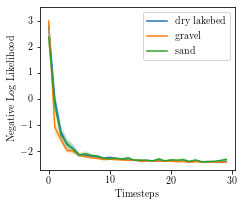

In [57]:
plt.figure(figsize=(3.5,3))
nll_plot(dry_nll_mean,dry_nll_var, gravel_nll_mean, gravel_nll_var, sand_nll_mean, sand_nll_var,N_test,legend=True)
plt.legend(['dry lakebed','gravel','sand'])
# plt.savefig('figures/nll_rockerbogie_terrains.pdf')
plt.show()

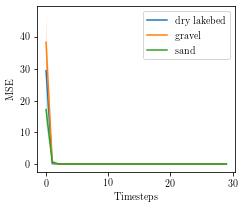

In [58]:
plt.figure(figsize=(3.5,3))
mse_plot(dry_mse_mean,dry_mse_var,gravel_mse_mean,gravel_mse_var,sand_mse_mean,sand_mse_var,N_test,legend=True)
plt.tight_layout()
plt.legend(['dry lakebed','gravel','sand'])
# plt.savefig('figures/mse_rockerbogie_terrains.pdf')
plt.show()

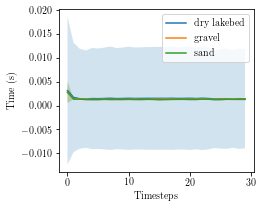

In [59]:
plt.figure(figsize=(3.5,3))
time_plot(dry_time_mean,dry_time_mean,gravel_time_mean, gravel_time_var,sand_time_mean, sand_time_var,N_test,legend=True)
plt.legend(['dry lakebed','gravel','sand'])
# plt.savefig('figures/time_rockerbogie_terrains.pdf')
plt.show()